<a href="https://akademie.datamics.com/kursliste/">![title](bg_datamics_top.png)</a>

<center><em>© Datamics</em></center><br><center><em>Besuche uns für mehr Informationen auf <a href='https://akademie.datamics.com/kursliste/'>www.akademie.datamics.com</a></em>

# Bildsegmentierung (Image Segementation) und der Wasserscheidentransformationsalgorithmus (Watershed Algorithm)

In [67]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

## Unsere Aufgabe: Zeichne Konturen um die Münzen

-----------------

## Beispiel gewöhnliche Münze

## Naiver Ansatz

Lasst uns einfach findContours mit einem Grenzwert versuchen.

### Beispielbild

In [69]:
sep_coins = cv2.imread('../DATA/pennies.jpg')

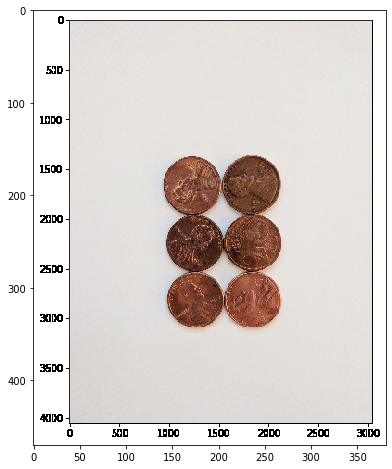

In [70]:
display(sep_coins)

### Mediane Unschärfe anwenden

Wir haben zu viele Details in diesem Bild, inklusive Licht, den Kanten der Gesichter auf den Münzen und zu vielen Details im Hintergrund. Lass uns zur Reduktion von Details mit medianer Unschärfe filtern, was später nützlich ist, wenn wir Grenzwerte anwenden.

In [71]:
sep_blur = cv2.medianBlur(sep_coins,25)

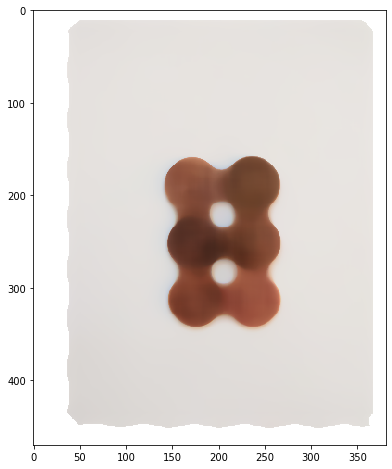

In [72]:
display(sep_blur)

In [73]:
gray_sep_coins = cv2.cvtColor(sep_blur,cv2.COLOR_BGR2GRAY)

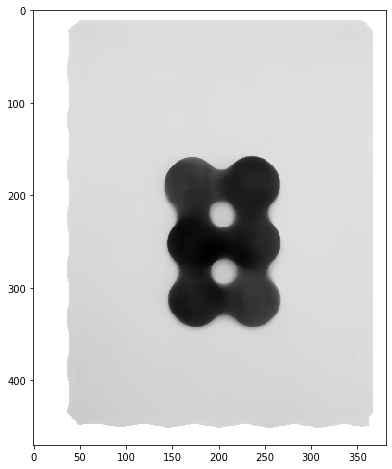

In [74]:
display(gray_sep_coins,cmap='gray')

## Binärer Grenzwert

In [75]:
ret, sep_thresh = cv2.threshold(gray_sep_coins,160,255,cv2.THRESH_BINARY_INV)

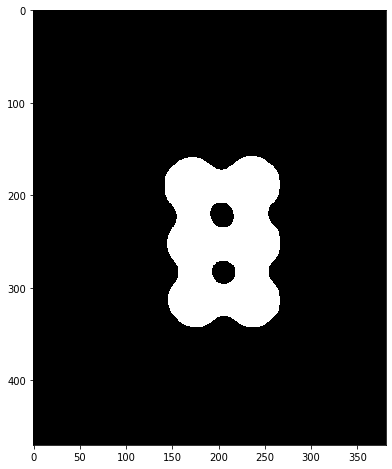

In [76]:
display(sep_thresh,cmap='gray')

## Konturenerkennung

In [77]:
contours, hierarchy = cv2.findContours(sep_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [78]:
# Für jede Kontur in contours
for i in range(len(contours)):
    
    # Die letzte Spalte im Array ist -1 wenn es sich um eine externe Kontur handelt (sie enthält keine inneren Konturen)
    if hierarchy[0][i][3] == -1:
        
        # Wir können jetzt die externen Konturen aus der Liste von Konturen zeichnen
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)

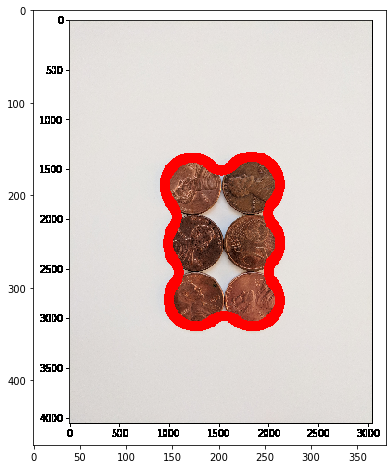

In [79]:
display(sep_coins)

# Wasserscheidentransformationsalgorithmus

-----------

Lasst uns jetzt den Wasserscheidentransformationsalgorithmus ausprobieren, um die Konturen der Pennies zu zeichen. Betrachte bitte das entsprechende Video zum Verständnis der Funktionsaufrufe hier.

## Anwendung des Wasserscheidentransformationsalgorithmus

#### Schritt 1: Bild einlesen

In [80]:
img = cv2.imread('../DATA/pennies.jpg')

#### Schritt 2: Unschärfe anwenden

In [81]:
img = cv2.medianBlur(img,35)

#### Schritt 3: Konvertierung zu Graustufen

In [82]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#### Schritt 4: Grenzwert anwenden (Invers binär mit OTSUl)

In [83]:
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

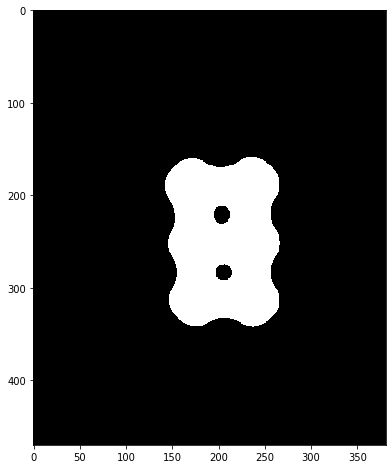

In [84]:
display(thresh,cmap='gray')

### Optionaler Schritt 5: Störsignalentfernung

In [85]:
# Störsignalentfernung
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

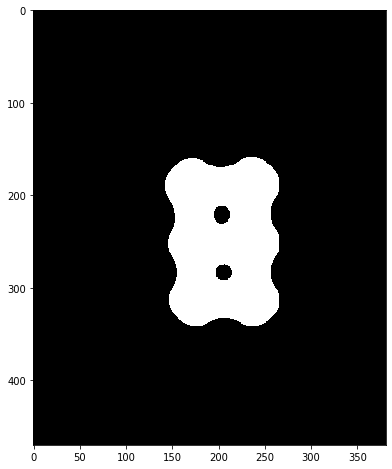

In [86]:
display(opening,cmap='gray')

#### Schritt 6: Finde den sicheren Hintergrund

In [87]:
# Sicherer Hintergrundbereich
sure_bg = cv2.dilate(opening,kernel,iterations=3)

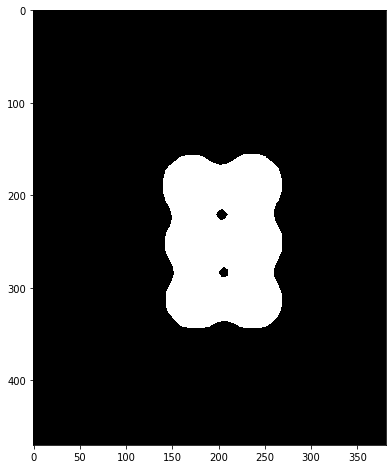

In [88]:
display(sure_bg,cmap='gray')

#### Schritt 7: Finde den sicheren Vordergrund

In [89]:
# Finde den sicheren Vordergrundbereich
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

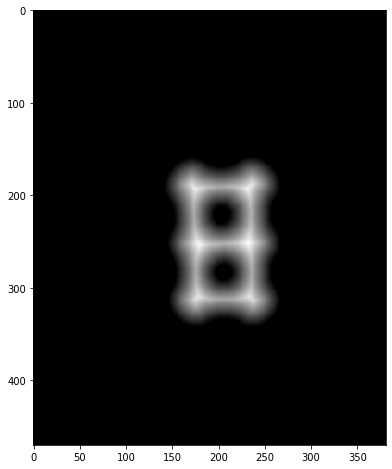

In [90]:
display(dist_transform,cmap='gray')

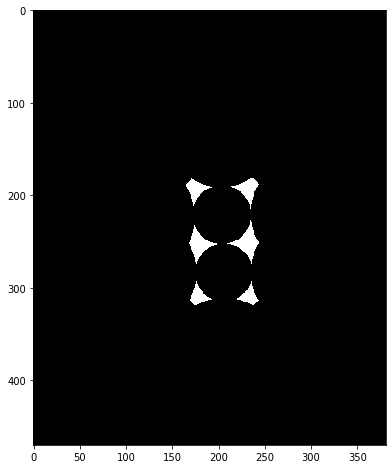

In [91]:
display(sure_fg,cmap='gray')

#### Schritt 8: Finde unbekannte Bereiche

In [92]:
# Finde unbekannte Bereiche
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

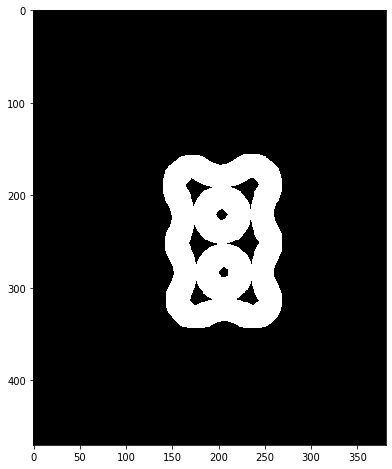

In [93]:
display(unknown,cmap='gray')

#### Schritt 9: Bringe Markierungen auf dem sicheren Vordergrund an

In [94]:
# Markierungs-Kennzeichnung
ret, markers = cv2.connectedComponents(sure_fg)
# Addiere Eins zu allen Markierungen, so dass der sichere Hintergrund nicht 0, sondern 1 ist
markers = markers+1
# Markiere jetzt unbekannte Bereiche mit Null
markers[unknown==255] = 0

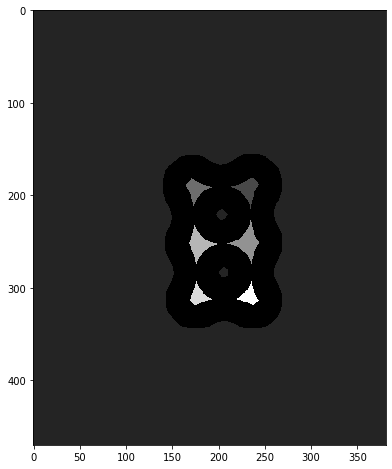

In [95]:
display(markers,cmap='gray')

#### Schritt 10: Wende den Wasserscheidentransformationsalgorithmus an, um Bereiche zu markieren

In [96]:
markers = cv2.watershed(img,markers)

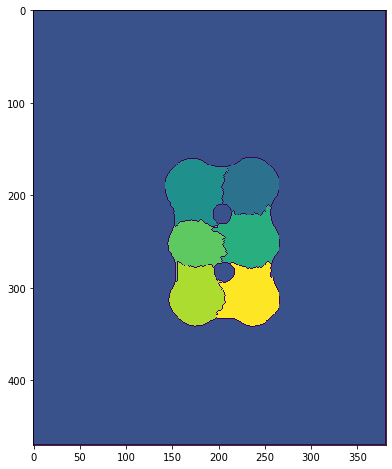

In [97]:
display(markers)

#### Schritt 11: Finde Konturen auf Markierungen

In [98]:
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# Für jede Kontur in contours
for i in range(len(contours)):
    
     # Die letzte Spalte im Array ist -1 wenn es sich um eine externe Kontur handelt (sie enthält keine inneren Konturen)
    if hierarchy[0][i][3] == -1:
        
        # Wir können jetzt die externen Konturen aus der Liste der Konturen zeichnen
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)

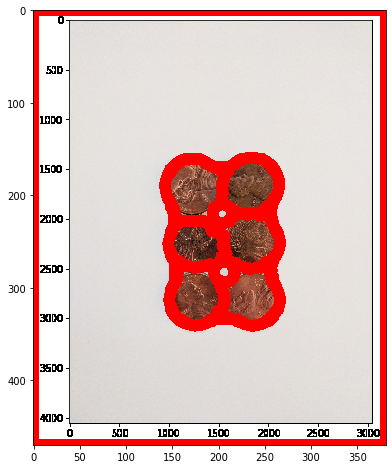

In [99]:
display(sep_coins)